In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import random
from numba import jit
from queue import Queue


from scipy.ndimage import convolve, generate_binary_structure

In [3]:
@jit(nopython=True)
def custom_mean(arr):
    # Custom implementation of mean calculation
    total = 0.0
    count = 0
    for x in arr:
        total += x
        count += 1
    return total / count if count != 0 else 0.0

In [4]:
@jit(nopython=True)
def custom_std(arr):
    
    # Custom implementation of standard deviation calculation
    mean_val = custom_mean(arr)
    variance = 0.0
    count = 0
    for x in arr:
        variance += (x - mean_val) ** 2
        count += 1
    return (variance / count) ** 0.5 if count != 0 else 0.0


In [5]:
@jit(nopython=True)
def energy_of_a_state(lattice):
    
    shape = lattice.shape
    
    Arr=np.zeros_like(lattice)
    
    for i in range(shape[0]):
        
        for j in range(shape[1]):
            
            for dx in [-1, 1]:
                
                if i + dx>=0 and i + dx< shape[0]:
                    
                    Arr[i, j] = Arr[i, j] - lattice[i, j] * lattice[i + dx, j]
                    
            for dy in [-1, 1]:
                
                if j + dy >= 0 and j+ dy < shape[1]:
                    Arr[i, j] = Arr[i, j] - lattice[i, j] * lattice[i, j + dy]
                    
    return Arr.sum()

    

In [6]:
@jit(nopython=True)
def WolfCluster(V, Visited, X, Y, BetaJ):
    L = len(V)
    
    q = []
    Vo = []
    q.append((X, Y))
    Spin = V[X][Y]
    
    while q:
        
        Xo, yo = q.pop(0)
        Vo.append((Xo, yo))
        
        if Xo + 1 < L:
            
            if V[Xo + 1][yo] == Spin and (1 - np.exp(-2 * BetaJ)) > np.random.rand() and Visited[Xo + 1][yo] == 0:
                
                q.append((Xo + 1, yo))
                Visited[Xo + 1][yo] = 1
                
        if Xo - 1 >= 0:
            
            if V[Xo - 1][yo] == Spin and (1 - np.exp(-2 * BetaJ)) > np.random.rand() and Visited[Xo - 1][yo] == 0:
                
                q.append((Xo - 1, yo))
                Visited[Xo - 1][yo] = 1
                
        if yo + 1 < L:
            
            if V[Xo][yo + 1] == Spin and (1 - np.exp(-2 * BetaJ)) >np.random.rand() and Visited[Xo][yo + 1] == 0:
                
                q.append((Xo, yo + 1))
                Visited[Xo][yo + 1] = 1
                
        if yo - 1 >= 0:
            
            if V[Xo][yo - 1] == Spin and (1 - np.exp(-2 * BetaJ)) > np.random.rand() and Visited[Xo][yo - 1] == 0:
                
                q.append((Xo, yo - 1))
                Visited[Xo][yo - 1] = 1
    
    for i in range(len(Vo)):
        
        V[Vo[i][0]][Vo[i][1]] = (-1) * Spin



In [7]:
@jit(nopython=True)

def FUNC(V, t, L, BetaJ):
    
    
    
    energy = []
    magnetisation = []
    
   
    
    
        
    
    
    while t > 0:
        
        t=t-1
        
        Visited = np.zeros((L , L ), dtype=np.int64)
        
        
        
        X = random.randint(0, L-1)
        Y = random.randint(0, L-1)
        
        WolfCluster(V, Visited, X, Y, BetaJ)
       
        energy.append(energy_of_a_state(V))
        
        total_magnetization = np.abs(np.sum(V))
        
        magnetisation.append(total_magnetization / (L * L))
        
        
        
    return (energy, magnetisation)


In [8]:






@jit(nopython=True)


def F(Temp_List, L):
    
    num_temps = len(Temp_List)
    mag_List = np.empty(num_temps, dtype=np.float64)
    energy_List = np.empty(num_temps, dtype=np.float64)
    heat_capacity = np.empty(num_temps, dtype=np.float64)
    Susceptibility = np.empty(num_temps, dtype=np.float64)
    
    V = np.ones((L, L), dtype=np.int32)  # Initialize V outside the loop
    
    for i in range(num_temps):
        
        items = Temp_List[i]
        energy, magnetisation = FUNC(V, 100000, L, 1/items)

        # Calculate mean of last 100 values
        mag_List[i] = custom_mean(magnetisation[-100:])
        energy_List[i] = custom_mean(energy[-100:])

        # Calculate heat capacity using custom standard deviation
        heat_capacity[i] = (custom_std(energy[-1000:]) ** 2) / (items ** 2)

        # Calculate susceptibility using custom standard deviation
        Susceptibility[i] = (custom_std(magnetisation[-1000:]) ** 2) / items

    return mag_List, energy_List, heat_capacity, Susceptibility


In [9]:
start=0.1
end=5.1

step=0.3
Temp=[i for i in range(int(start*10), int(end*10), int(step*10))]
Temp=[i/10 for i in Temp]
L=100
mag_List, energy_List, heat_capacity, Susceptibility=F(Temp, L)




/opt/conda/lib/python3.10/site-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'Temp_List' of function 'F'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_34/4229769594.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [10]:
mag_List

array([1.      , 1.      , 0.999938, 0.998916, 0.9934  , 0.974506,
       0.92342 , 0.671946, 0.059348, 0.035944, 0.007486, 0.022226,
       0.037722, 0.004758, 0.012754, 0.022274, 0.021046])

In [11]:
energy_List

array([-39600.  , -39600.  , -39595.88, -39523.4 , -39149.32, -37970.12,
       -35416.16, -29695.08, -21823.08, -17739.  , -16179.72, -14612.6 ,
       -12759.4 , -11792.32, -11303.72, -10256.12,  -9145.64])

In [12]:
heat_capacity

array([    0.        ,     0.        ,    78.45848163,  1029.205504  ,
        4373.8499787 , 11443.2466    , 24344.69471025, 63080.21632727,
       43318.08745216, 16772.77118163,  2726.88719917,  2110.10905329,
        1791.99418437,  1226.013436  ,  5035.304996  ,   970.31570813,
         378.66991154])

In [13]:
Susceptibility

array([0.00000000e+00, 0.00000000e+00, 1.25174857e-08, 2.18919000e-07,
       1.44269018e-06, 6.72042750e-06, 3.94258028e-05, 5.37945273e-03,
       8.84906602e-04, 1.44344407e-04, 1.00082812e-04, 2.84695773e-05,
       5.63332931e-05, 7.68511620e-05, 1.02379482e-05, 6.95041517e-06,
       1.07840390e-05])

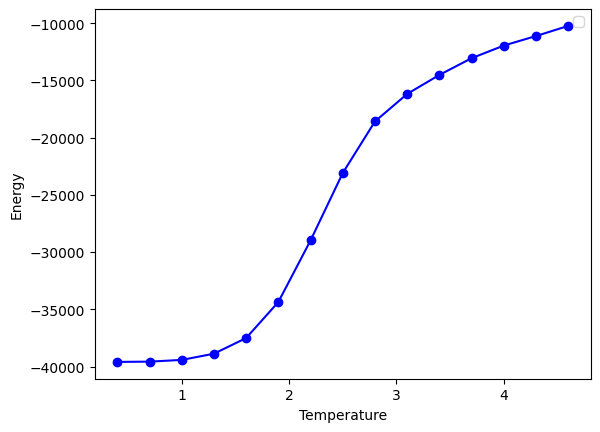

In [14]:




# Define the window size for the moving average
window_size = 3

# Calculate the moving average of energy
smooth_energy = np.convolve(energy_List, np.ones(window_size)/window_size, mode='valid')
# Adjust temperature array to match the smoothed energy array
smooth_temp = Temp[window_size//2:-(window_size//2)]

# Plot the smoothed curve with markers
plt.plot(smooth_temp, smooth_energy, 'b-', marker='o')

# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.legend()

# Show plot
plt.show()


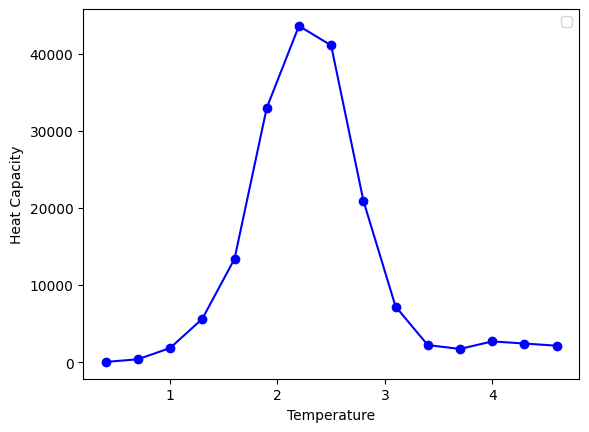

In [15]:
window_size = 3

# Calculate the moving average of energy
smooth_energy = np.convolve(heat_capacity, np.ones(window_size)/window_size, mode='valid')
# Adjust temperature array to match the smoothed energy array
smooth_temp = Temp[window_size//2:-(window_size//2)]

# Plot the smoothed curve with markers
plt.plot(smooth_temp, smooth_energy, 'b-', marker='o')


# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('Heat Capacity')
plt.legend()

# Show plot
plt.show()

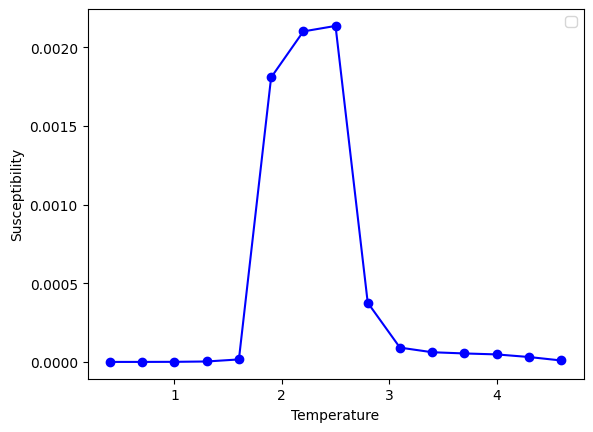

In [16]:
window_size = 3

# Calculate the moving average of energy
smooth_energy = np.convolve(Susceptibility, np.ones(window_size)/window_size, mode='valid')
# Adjust temperature array to match the smoothed energy array
smooth_temp = Temp[window_size//2:-(window_size//2)]

# Plot the smoothed curve with markers
plt.plot(smooth_temp, smooth_energy, 'b-', marker='o')

# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.legend()

# Show plot
plt.show()

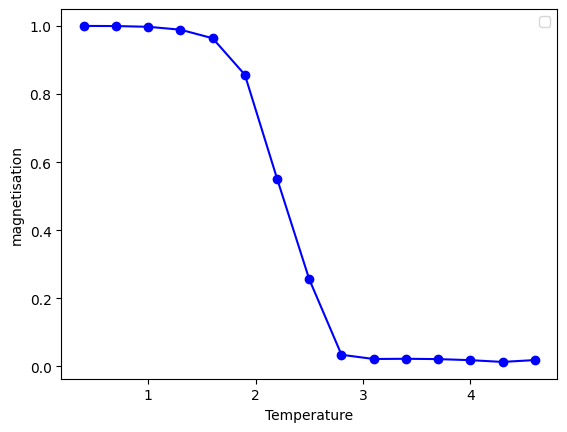

In [17]:
window_size=3

# Calculate the moving average of energy
smooth_energy = np.convolve(mag_List, np.ones(window_size)/window_size, mode='valid')
# Adjust temperature array to match the smoothed energy array
smooth_temp = Temp[window_size//2:-(window_size//2)]

# Plot the smoothed curve with markers
plt.plot(smooth_temp, smooth_energy, 'b-', marker='o')

# Add labels and legend
plt.xlabel('Temperature')
plt.ylabel('magnetisation')
plt.legend()

# Show plot
plt.show()

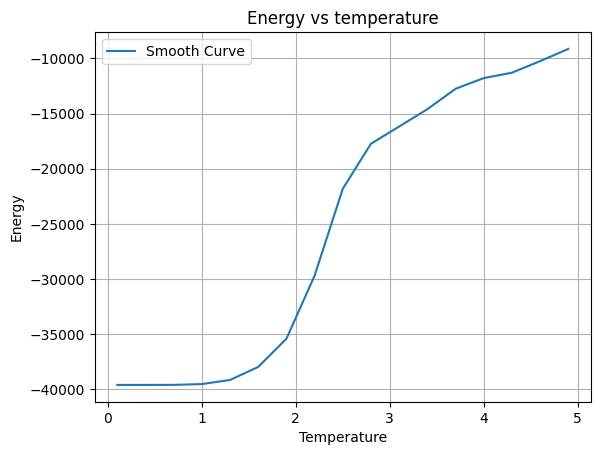

In [18]:
x=Temp
y=energy_List

plt.plot(x, y, label='Smooth Curve')


plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs temperature')


plt.grid(True)


plt.legend()


plt.show()

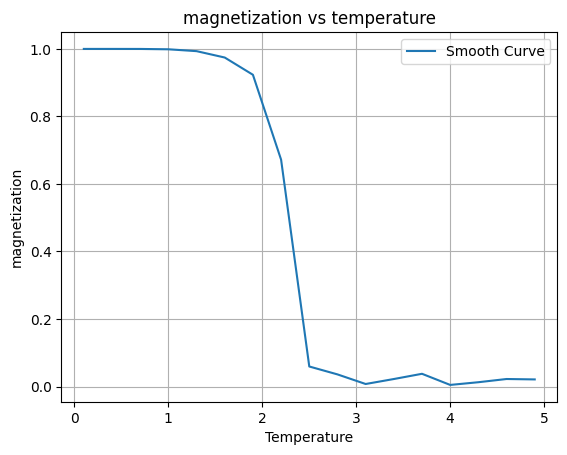

In [19]:
x = Temp
y = mag_List

plt.plot(x, y, label='Smooth Curve')


plt.xlabel('Temperature')
plt.ylabel('magnetization')
plt.title('magnetization vs temperature')


plt.grid(True)


plt.legend()


plt.show()


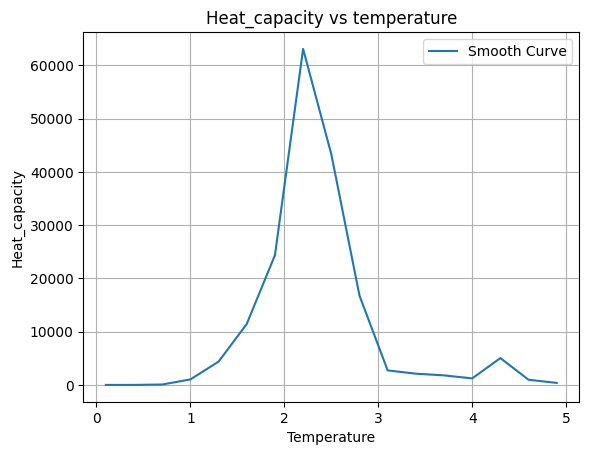

In [20]:
x=Temp
y=heat_capacity

plt.plot(x, y, label='Smooth Curve')


plt.xlabel('Temperature')
plt.ylabel('Heat_capacity')
plt.title('Heat_capacity vs temperature')


plt.grid(True)



plt.legend()


plt.show()
    

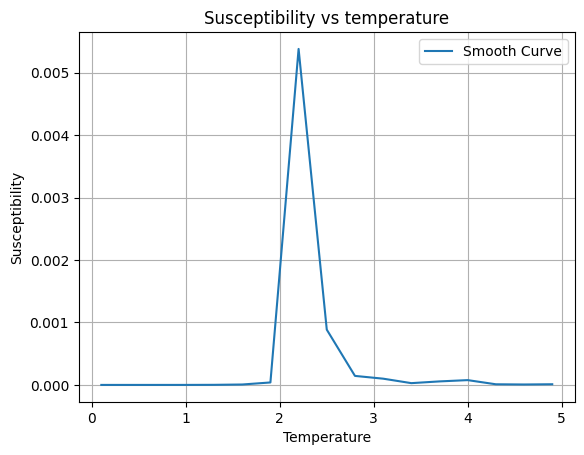

In [21]:
x=Temp
y=Susceptibility

plt.plot(x, y, label='Smooth Curve')


plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.title('Susceptibility vs temperature')


plt.grid(True)



plt.legend()


plt.show()
    